## 1. Setup and database connection

In [25]:
import pandas as pd
import numpy as np
import sqlite3
import warnings
import os
from pathlib import Path
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, accuracy_score, f1_score
)
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

import joblib
from datetime import datetime

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

All libraries imported successfully!
Analysis Date: 2025-07-23 22:19:15


In [26]:
DB_PATH = '/Users/sophie/Desktop/Uni_year_2/project-at2024-theolympians/Group_Project/olympics_SQL.db'

# Check if database exists
if not os.path.exists(DB_PATH):
    print(f"Database not found at {DB_PATH}")
    print("Please ensure the database file is in the correct location.")
else:
    print(f"Database found: {DB_PATH}")

    conn = sqlite3.connect(DB_PATH)
    
    tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
    tables = pd.read_sql_query(tables_query, conn)
    
    print(f"Available tables: {', '.join(tables['name'].tolist())}")
    print(f"Database size: {os.path.getsize(DB_PATH) / 1024 / 1024:.2f} MB")

Database found: /Users/sophie/Desktop/Uni_year_2/project-at2024-theolympians/Group_Project/olympics_SQL.db
Available tables: COUNTRY, COUNTRY_DETAILS, SPORT, OLYMPIC, SINGLES_EVENT, TEAM_EVENT, OLYMPIC_SPORT, PART_OF, ATHLETE, PARTICIPATES, TEAM
Database size: 6.91 MB


## 2. Exploratory data analysis

In [27]:
data_extraction_query = """
SELECT DISTINCT
    a.athleteID,
    a.name as athlete_name,
    a.height,
    a.weight,
    a.bodyFat,
    a.heartRateVariability,
    a.vo2Max,
    a.bloodOxygen,
    a.injurySeverityScore,
    c.name as country,
    cd.gdp,
    cd.population,
    cd.year as country_year,
    p.ranking,
    p.year as participation_year,
    se.eventName as event_name,
    s.sportName,
    -- Create medal categories
    CASE 
        WHEN p.ranking = 1 THEN 'Gold'
        WHEN p.ranking = 2 THEN 'Silver' 
        WHEN p.ranking = 3 THEN 'Bronze'
        ELSE 'No Medal'
    END as medal_category,
    -- Binary target variable
    CASE 
        WHEN p.ranking <= 3 THEN 1 
        ELSE 0 
    END as has_medal
FROM ATHLETE a
JOIN PARTICIPATES p ON a.athleteID = p.athleteID
JOIN SINGLES_EVENT se ON p.eventID = se.eventID
JOIN SPORT s ON se.sportId = s.sportId
JOIN COUNTRY c ON a.noc = c.noc
JOIN COUNTRY_DETAILS cd ON c.noc = cd.noc AND cd.year = p.year
WHERE p.ranking IS NOT NULL
    AND a.height IS NOT NULL
    AND a.weight IS NOT NULL
    AND cd.gdp IS NOT NULL
    AND cd.population IS NOT NULL
ORDER BY p.year, a.athleteID
"""

try:
    df = pd.read_sql_query(data_extraction_query, conn)
    
    print(f"Successfully extracted {len(df):,} records")
    print(f"Unique athletes: {df['athleteID'].nunique():,}")
    print(f"Countries represented: {df['country'].nunique()}")
    print(f"Sports included: {df['sportName'].nunique()}")
    print(f"Events covered: {df['event_name'].nunique()}")
    
    # Medal distribution
    print(f"\nMedal Distribution:")
    medal_dist = df['medal_category'].value_counts()
    for medal, count in medal_dist.items():
        percentage = (count / len(df)) * 100
        print(f"   {medal}: {count:,} ({percentage:.1f}%)")
    
    # Display sample data
    print(f"\nSample Data:")
    display(df.head(3))
    
except Exception as e:
    print(f"Error extracting data: {e}")
    print("This might be due to missing tables or different schema structure.")

Successfully extracted 21,398 records
Unique athletes: 12,354
Countries represented: 167
Sports included: 48
Events covered: 266

Medal Distribution:
   No Medal: 19,090 (89.2%)
   Bronze: 907 (4.2%)
   Silver: 708 (3.3%)
   Gold: 693 (3.2%)

Sample Data:


,athleteID,athlete_name,height,weight,bodyFat,heartRateVariability,vo2Max,bloodOxygen,injurySeverityScore,country,gdp,population,country_year,ranking,participation_year,event_name,sportName,medal_category,has_medal
0,7,Patrick Chila,180.0,73.0,9.478610,90.131814,64.186082,99.241007,5.0,France,2.926803e+12,64379696,2008,49,2008,"Singles, Men",Table Tennis,No Medal,0
1,15,Damien Éloi,165.0,58.0,14.560510,67.722398,61.741788,96.418747,3.0,France,2.926803e+12,64379696,2008,33,2008,"Singles, Men",Table Tennis,No Medal,0
2,27,Christophe Legoût,177.0,75.0,9.714766,94.175905,60.406506,98.754808,0.0,France,2.926803e+12,64379696,2008,49,2008,"Singles, Men",Table Tennis,No Medal,0


## 3. Feature engineering

In [28]:
df_features = df.copy()

# 1. Basic derived features
df_features['gdp_per_capita'] = df_features['gdp'] / df_features['population']
df_features['bmi'] = df_features['weight'] / ((df_features['height'] / 100) ** 2)
df_features['height_weight_ratio'] = df_features['height'] / df_features['weight']

# 2. Age estimation
df_features['estimated_age'] = 20 + (df_features['participation_year'] - 2008) * 0.3

# 3. Health composite score
df_features['fitness_score'] = (
    df_features['vo2Max'] * 0.4 + 
    df_features['bloodOxygen'] * 0.3 + 
    (100 - df_features['bodyFat']) * 0.2 +
    df_features['heartRateVariability'] * 0.1
)

df_features['risk_score'] = (
    df_features['injurySeverityScore'] * 0.6 +
    df_features['bodyFat'] * 0.4
)

# 4. Country-level performance metrics
country_stats = df_features.groupby('country').agg({
    'has_medal': ['mean', 'count', 'sum'],
    'ranking': 'mean',
    'gdp_per_capita': 'mean'
}).round(4)

country_stats.columns = [
    'country_medal_rate', 'country_total_athletes', 'country_total_medals',
    'country_avg_ranking', 'country_avg_gdp_per_capita'
]
country_stats = country_stats.reset_index()

# Merge back with main dataset
df_features = df_features.merge(country_stats, on='country', how='left')

# 5. Sport-level performance metrics
sport_stats = df_features.groupby('sportName').agg({
    'has_medal': ['mean', 'count'],
    'ranking': 'mean',
    'fitness_score': 'mean'
}).round(4)

sport_stats.columns = [
    'sport_medal_rate', 'sport_total_participants', 
    'sport_avg_ranking', 'sport_avg_fitness'
]
sport_stats = sport_stats.reset_index()

df_features = df_features.merge(sport_stats, on='sportName', how='left')

print(f"Total features created: {df_features.shape[1]}")
print(f"Dataset shape: {df_features.shape}")

Total features created: 34
Dataset shape: (21398, 34)


## 4. Model dev

In [29]:
# Feature selection
feature_columns = [
    'height', 'weight', 'bmi', 'bodyFat', 'heartRateVariability', 
    'vo2Max', 'bloodOxygen', 'injurySeverityScore',
    'fitness_score', 'risk_score', 'estimated_age',
    'gdp_per_capita', 'country_medal_rate', 'country_avg_ranking', 
    'sport_medal_rate', 'sport_avg_ranking'
]

available_features = [col for col in feature_columns if col in df_features.columns]

X = df_features[available_features].copy()
y = df_features['has_medal'].copy()

# Handle missing values
X = X.fillna(X.median())

print(f"Selected {len(available_features)} features for modeling")
print(f"Feature matrix shape: {X.shape}")
print(f"Medal rate: {y.mean():.1%}")

Selected 16 features for modeling
Feature matrix shape: (21398, 16)
Medal rate: 10.8%


In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

Training set: 17,118 samples
Test set: 4,280 samples


In [31]:
print("Baseline Gradient Boosting Model:")

baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3
    ))
])

# Train baseline model
baseline_pipeline.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(
    baseline_pipeline, X_train, y_train, 
    cv=5, scoring='roc_auc'
)

print(f"CV AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

Baseline Gradient Boosting Model:
CV AUC: 0.7506 (±0.0101)


In [32]:
print("Hyperparameter Optimization:")

param_grid = {
    'gb__n_estimators': [100, 200],
    'gb__learning_rate': [0.05, 0.1, 0.15],
    'gb__max_depth': [3, 4, 5],
    'gb__min_samples_split': [10, 20]
}

grid_search = GridSearchCV(
    baseline_pipeline,
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best CV Score: {grid_search.best_score_:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")

# Get best model
best_model = grid_search.best_estimator_

Hyperparameter Optimization:
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best CV Score: 0.7578
Best Parameters: {'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__min_samples_split': 10, 'gb__n_estimators': 100}


## 5. Testing and visualisation

In [33]:
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, y_test_pred_proba)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"FINAL TEST RESULTS:")
print(f"   AUC-ROC:  {test_auc:.4f}")
print(f"   Accuracy: {test_accuracy:.4f}")
print(f"   F1-Score: {test_f1:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No Medal', 'Medal']))

FINAL TEST RESULTS:
   AUC-ROC:  0.7646
   Accuracy: 0.8963
   F1-Score: 0.1591

Classification Report:
              precision    recall  f1-score   support

    No Medal       0.90      0.99      0.94      3818
       Medal       0.64      0.09      0.16       462

    accuracy                           0.90      4280
   macro avg       0.77      0.54      0.55      4280
weighted avg       0.87      0.90      0.86      4280



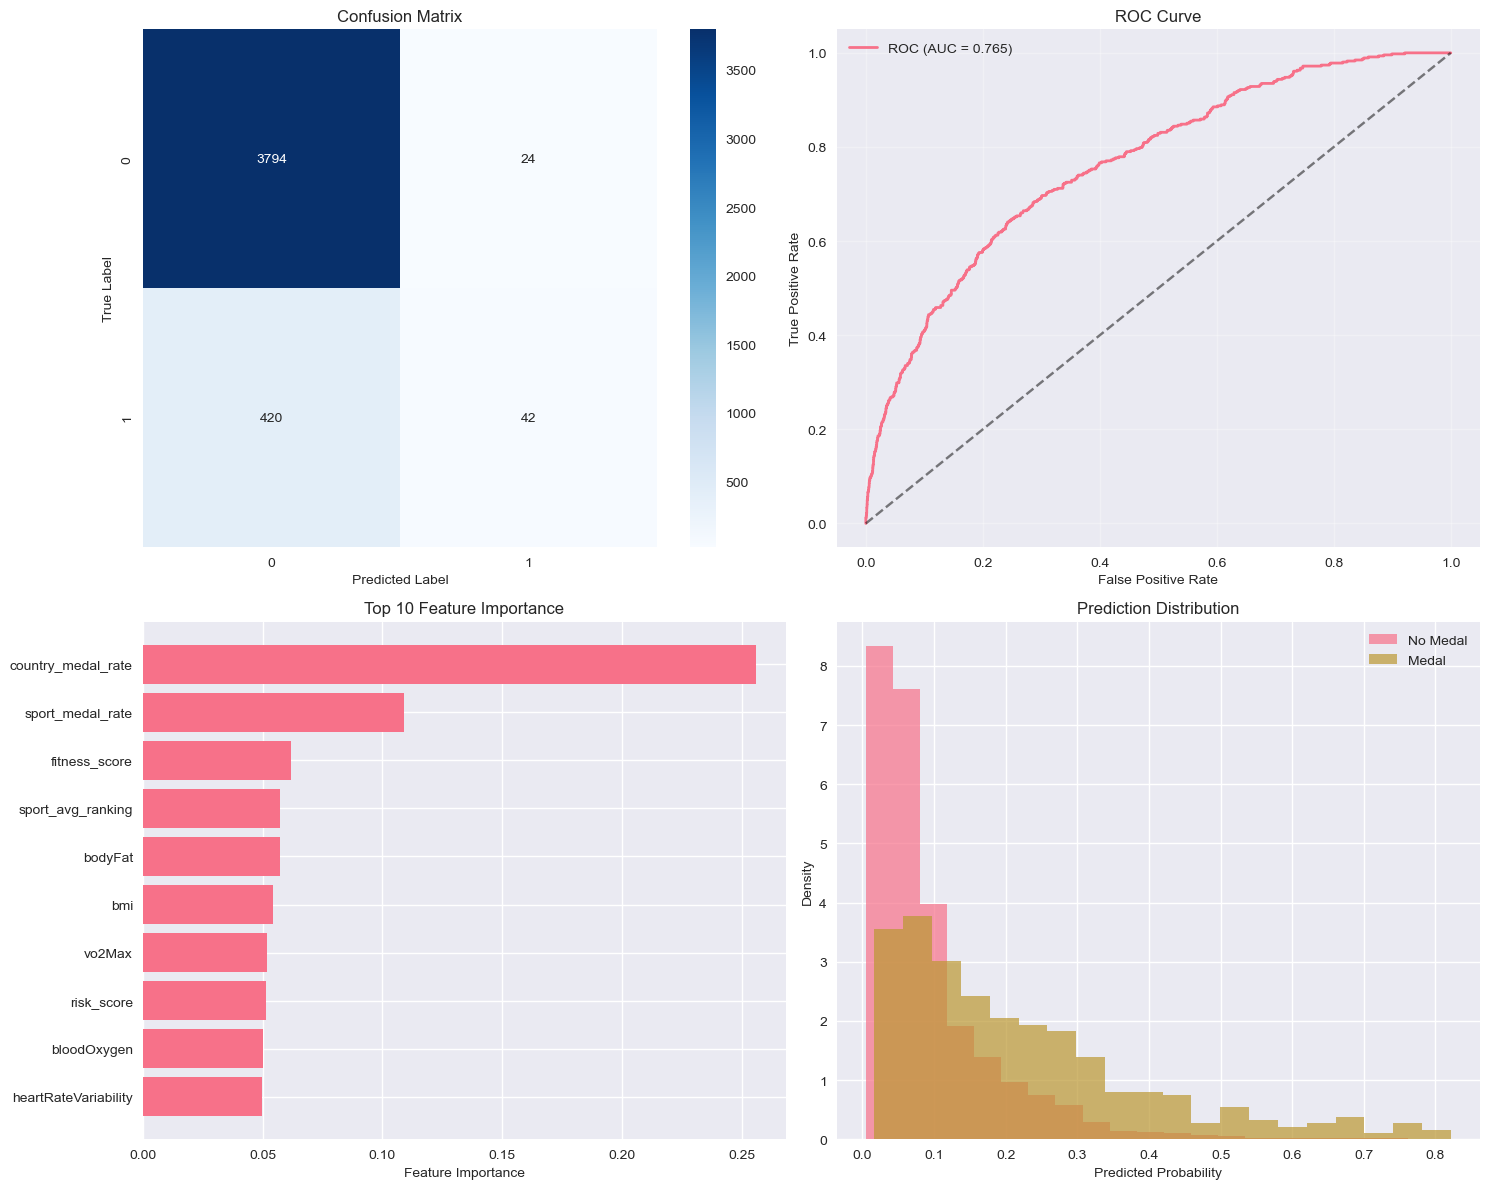

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {test_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': best_model['gb'].feature_importances_
}).sort_values('importance', ascending=True).tail(10)

axes[1, 0].barh(range(len(feature_importance)), feature_importance['importance'])
axes[1, 0].set_yticks(range(len(feature_importance)))
axes[1, 0].set_yticklabels(feature_importance['feature'])
axes[1, 0].set_xlabel('Feature Importance')
axes[1, 0].set_title('Top 10 Feature Importance')

# Prediction Distribution
axes[1, 1].hist(y_test_pred_proba[y_test == 0], bins=20, alpha=0.7, label='No Medal', density=True)
axes[1, 1].hist(y_test_pred_proba[y_test == 1], bins=20, alpha=0.7, label='Medal', density=True)
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Prediction Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


## 6. Feature ranking

In [35]:
feature_importance_df = pd.DataFrame({
    'feature': available_features,
    'importance': best_model['gb'].feature_importances_
}).sort_values('importance', ascending=False)

print("10 most important features:")
print("=" * 45)
for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<25}: {row['importance']:.4f}")

feature_categories = {
    'Physical': ['height', 'weight', 'bmi'],
    'Health': ['bodyFat', 'heartRateVariability', 'vo2Max', 'bloodOxygen', 'injurySeverityScore'],
    'Derived': ['fitness_score', 'risk_score', 'estimated_age'],
    'Economic': ['gdp_per_capita'],
    'Performance': ['country_medal_rate', 'country_avg_ranking', 'sport_medal_rate', 'sport_avg_ranking']
}

print(f"\nBy category:")
print("=" * 40)
for category, features in feature_categories.items():
    category_importance = feature_importance_df[
        feature_importance_df['feature'].isin(features)
    ]['importance'].sum()
    print(f"{category:<12}: {category_importance:.4f}")

10 most important features:
 1. country_medal_rate       : 0.2557
 2. sport_medal_rate         : 0.1088
 3. fitness_score            : 0.0619
 4. sport_avg_ranking        : 0.0573
 5. bodyFat                  : 0.0572
 6. bmi                      : 0.0542
 7. vo2Max                   : 0.0520
 8. risk_score               : 0.0513
 9. bloodOxygen              : 0.0503
10. heartRateVariability     : 0.0496

By category:
Physical    : 0.1354
Health      : 0.2221
Derived     : 0.1287
Economic    : 0.0471
Performance : 0.4667


## 7. Saving model

In [36]:
model_metadata = {
    'model_name': 'Olympic Medal Predictor - Gradient Boosting',
    'model_type': 'GradientBoostingClassifier',
    'test_auc': test_auc,
    'test_accuracy': test_accuracy,
    'test_f1': test_f1,
    'cv_score': grid_search.best_score_,
    'best_params': grid_search.best_params_,
    'feature_names': available_features,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

# Save model and metadata
joblib.dump(best_model, 'olympic_medal_predictor_gb.pkl')
joblib.dump(model_metadata, 'model_metadata.pkl')

print(f"\nSummary:")
print(f"   Test AUC: {test_auc:.4f}")
print(f"   Features: {len(available_features)}")
print(f"   Training samples: {len(X_train):,}")



Summary:
   Test AUC: 0.7646
   Features: 16
   Training samples: 17,118
